LBFGS with Residual-based Adaptive Refinement (RAR)

Algorithm

Define physics and boundary conditions.

Build a sine-activated neural network.

Wrap the NN in a trial solution that enforces boundaries exactly.

Compute PDE residuals via automatic differentiation.

Train iteratively in RAR cycles:

    L-BFGS optimization → sample refinement → repeat.

Optionally finish with a global L-BFGS polish.

Evaluate on a dense grid and compare with the known analytical solution.

Cycle  1: L-BFGS loss=4.991e+02, max cand |r|=2.390e+01
Cycle  2: L-BFGS loss=3.185e+02, max cand |r|=1.699e+01
Cycle  3: L-BFGS loss=2.120e+02, max cand |r|=1.347e+02
Cycle  4: L-BFGS loss=1.746e+03, max cand |r|=4.629e+01
Cycle  5: L-BFGS loss=3.226e+02, max cand |r|=6.710e+01

Final L-BFGS loss: 5.164e+02
Total time: 59.5s
Total collocation points used: 2000


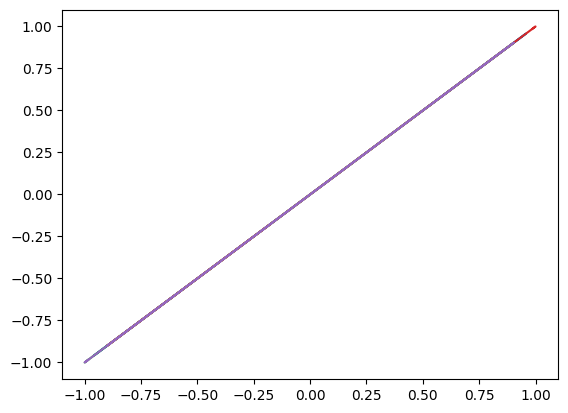

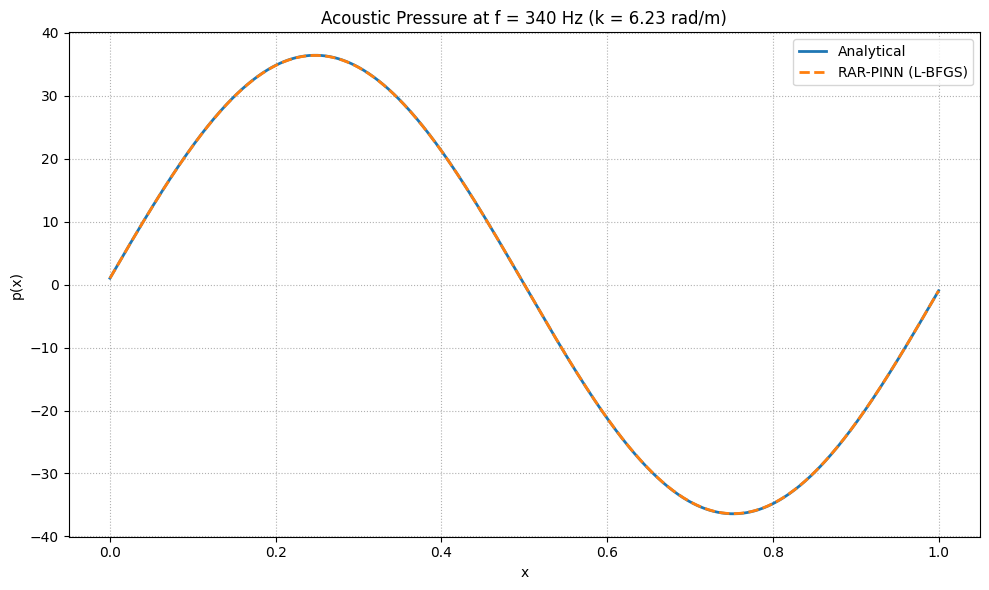

In [ ]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_rar(
    k,
    A,
    B,
    layers,
    N_colloc=2000,           # total collocation budget
    N_cycles=5,              # number of RAR cycles
    iters_per_cycle=100,     # L-BFGS max_iter per cycle
    cand_pool=50000,         # candidate pool size
    refine_frac=0.1,         # fraction to replace each cycle
    c=343.0,
    L=1.0,
    final_lbfgs=True,        # final global L-BFGS pass?
    lbfgs_options=None       # extra options for final L-BFGS
):
    t0 = time.perf_counter()
    # Physical constants

    # PINN
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.net = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.net:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)
        def forward(self, x):
            y = x
            for lin in self.net[:-1]:
                y = self.act(lin(y))
            return self.net[-1](y)

    device = torch.device('cpu')
    net = PINN(layers).to(device)

    def trial(xh): # Defines the trial solution that automatically satisfies boundary conditions.
        x_phys = (xh + 1)*(L/2)
        p_nn = net(xh)
        return (1 - x_phys/L)*A + (x_phys/L)*B + x_phys*(L - x_phys)*p_nn

    def residual(xh): # Computes the PDE residual (d^2p/dx^2+k^2p=0) in normalized coordinates
        p = trial(xh) # PINN’s prediction (trial‐solution)
        dp  = torch.autograd.grad(p, xh,
                                  grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]
        d2p = torch.autograd.grad(dp, xh,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return (2.0/L)**2 * d2p + k**2 * p

    # initialize collocation
    x_colloc = torch.rand(N_colloc,1, device=device)*2 - 1 # Samples N_colloc random points uniformly in [−1,1].
    replace_N = int(refine_frac * N_colloc) # Computes how many points to replace each refinement cycle.
    colloc_history = []  # Will store the physical x-coordinates each cycle
    x_phys1 = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
    colloc_history.append(x_phys1)

    for cycle in range(1, N_cycles+1): # Outer loop over RAR cycles
        # — train this cycle with a tamer L-BFGS —
        lbfgs_cycle = torch.optim.LBFGS(
            net.parameters(),
            lr=0.1,              
            max_iter=iters_per_cycle,
            tolerance_grad=1e-9,
            tolerance_change=1e-12,
            history_size=50,
        )
        def closure(): # L-BFGS in PyTorch requires a “closure” function that recomputes loss and gradients.
            lbfgs_cycle.zero_grad() # Clears any previous gradients.
            x_in = x_colloc.clone().requires_grad_(True)
            res = residual(x_in)
            loss = torch.mean(res**2) #Defines the loss as the mean squared residual
            if not torch.isfinite(loss):
                raise RuntimeError(f"NaN loss in cycle {cycle}")
            loss.backward() # Backpropagates to compute gradients of loss w.r.t. network weights.
            return loss

        try:
            loss = lbfgs_cycle.step(closure).item() #This tells L-BFGS to run its “inner loop” up to 100 iterations
        except RuntimeError as err:
            print(err)
            print("Reducing lr further or checking initialization may help.")
            return None

        # — residual sampling and refinement —
        x_cand = (torch.rand(cand_pool,1, device=device)*2 - 1).requires_grad_(True) # draw cand_pool fresh random points
        r_cand = residual(x_cand).abs().flatten().detach() # compute absolute residuals at these candidates
        idx_top = torch.topk(r_cand, replace_N).indices # indices of the replace_N points with largest residuals
        x_add = x_cand[idx_top].detach() # those high‐error points we want to add

        x_req = x_colloc.clone().detach().requires_grad_(True) 
        r_coll = residual(x_req).abs().flatten().detach() # compute residuals at current collocation
        idx_keep = torch.topk(r_coll, N_colloc - replace_N).indices # pick the N_colloc - replace_N points with the smallest residuals
        x_colloc = torch.cat([x_colloc[idx_keep], x_add], dim=0) # Replace the worst replace_N old points with the best replace_N new candidates.
        #plt.plot(x_colloc,x_colloc)

        print(f"Cycle {cycle:2d}: L-BFGS loss={loss:.3e}, max cand |r|={r_cand.max():.3e}")

    # final global L-BFGS
    if final_lbfgs:
        opts = dict(lr=0.1,             # <<< also reduce final lr
                    max_iter=2000,
                    tolerance_grad=1e-9,
                    tolerance_change=1e-12,
                    history_size=50)
        if lbfgs_options:
            opts.update(lbfgs_options)

        lbfgs_final = torch.optim.LBFGS(net.parameters(), **opts)
        def closure_final():
            lbfgs_final.zero_grad()
            x_in = x_colloc.clone().detach().requires_grad_(True)
            res = residual(x_in)
            loss = torch.mean(res**2)
            if not torch.isfinite(loss):
                raise RuntimeError("NaN loss in final L-BFGS")
            loss.backward()
            return loss

        try:
            final_loss = lbfgs_final.step(closure_final).item()
            print(f"\nFinal L-BFGS loss: {final_loss:.3e}")
        except RuntimeError as err:
            print(err)
            print("Consider lowering the final lr or skipping final L-BFGS.")

    elapsed = time.perf_counter() - t0
    print(f"Total time: {elapsed:.1f}s")
    print(f"Total collocation points used: {x_colloc.shape[0]}")

    # evaluate for plotting
    x_plot = torch.linspace(0, L, 800).unsqueeze(-1)
    xh_plot = 2*(x_plot/L) - 1
    with torch.no_grad():
        p_pred = trial(xh_plot.to(device)).cpu().numpy().flatten() # Computes the PINN’s predicted pressure at the plotting points

    x_np   = x_plot.numpy().flatten()
    p_true = (A*np.cos(k*x_np)
              + ((B - A*np.cos(k*L))/np.sin(k*L))*np.sin(k*x_np)) # Computes the closed-form analytical solution of the Helmholtz equation for comparison

    return x_np, p_pred, p_true, k

# example usage
if __name__ == "__main__":
    freq = 340
    c = 343.0
    k_val = 2 * np.pi * freq / c
    A_val = 1.0
    B_val = -1.0
    out = solve_helmholtz_pinn_rar(
        k=k_val,
        A=A_val,
        B=B_val,
        layers=[1,120,120,120,1],
        N_colloc=2000,
        N_cycles=5,
        iters_per_cycle=100,
        cand_pool=30000,
        refine_frac=0.1,
        final_lbfgs=True
    )
    if out:
        x, p_pred, p_true, k_val = out
        plt.figure(figsize=(10,6))
        plt.plot(x, p_true,  label='Analytical', linewidth=2)
        plt.plot(x, p_pred, '--', label='RAR-PINN (L-BFGS)', linewidth=2)
        plt.title(f'Acoustic Pressure at f = {freq} Hz (k = {k_val:.2f} rad/m)')
        plt.xlabel('x'); plt.ylabel('p(x)')
        plt.grid(which='both', linestyle=':')
        plt.legend(); plt.tight_layout()
        plt.show()


Cycle  1 completed — recorded 200 points.
Cycle  2 completed — recorded 200 points.
Cycle  3 completed — recorded 200 points.
Cycle  4 completed — recorded 200 points.
Cycle  5 completed — recorded 200 points.


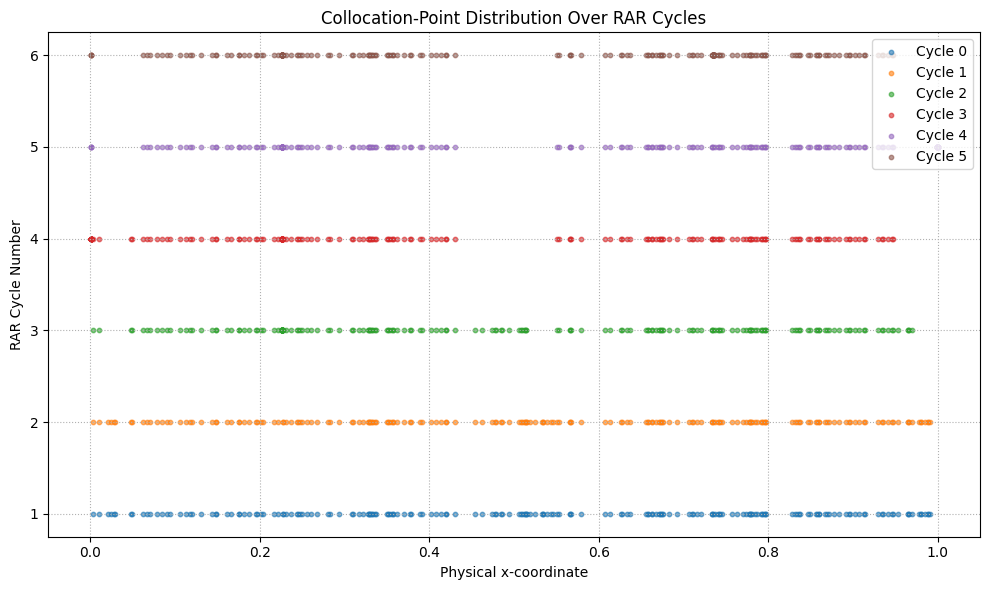

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_rar_record(
    k,
    A,
    B,
    layers,
    N_colloc=200,            # reduced for quicker runs—feel free to increase
    N_cycles=5,              # number of RAR cycles
    iters_per_cycle=100,     # L-BFGS max_iter per cycle
    cand_pool=30000,         # candidate pool size (can scale up for accuracy)
    refine_frac=0.1,         # fraction of points to replace per cycle
    c=343.0,
    L=1.0
):
    device = torch.device('cpu')

    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.net = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.net:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.net[:-1]:
                y = self.act(lin(y))
            return self.net[-1](y)

    net = PINN(layers).to(device)

    def trial(xh):
        # Map from normalized [-1,1] → physical [0,L]
        x_phys = (xh + 1) * (L / 2)
        p_nn = net(xh)
        return (1 - x_phys / L) * A + (x_phys / L) * B + x_phys * (L - x_phys) * p_nn

    def residual(xh):
        p = trial(xh)
        dp = torch.autograd.grad(p, xh, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        d2p = torch.autograd.grad(dp, xh, grad_outputs=torch.ones_like(dp), create_graph=True)[0]
        return (2.0 / L)**2 * d2p + k**2 * p

    # Initialize collocation points in normalized space [-1,1]
    x_colloc = torch.rand(N_colloc, 1, device=device) * 2 - 1
    replace_N = int(refine_frac * N_colloc)
    colloc_history = []  # Will store the physical x-coordinates each cycle
    x_phys1 = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
    colloc_history.append(x_phys1)

    for cycle in range(1, N_cycles + 1):
        # — train for this cycle with L-BFGS —
        lbfgs = torch.optim.LBFGS(
            net.parameters(),
            lr=0.1,
            max_iter=iters_per_cycle,
            tolerance_grad=1e-9,
            tolerance_change=1e-12,
            history_size=50
        )

        def closure():
            lbfgs.zero_grad()
            x_req = x_colloc.clone().requires_grad_(True)
            res = residual(x_req)
            loss = torch.mean(res**2)
            loss.backward()
            return loss

        lbfgs.step(closure)

        # Record collocation set (in physical domain) after this cycle
        x_phys = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
        colloc_history.append(x_phys)

        # — residual sampling & refinement —
        x_cand = (torch.rand(cand_pool, 1, device=device) * 2 - 1).requires_grad_(True)
        r_cand = residual(x_cand).abs().flatten().detach()
        idx_top = torch.topk(r_cand, replace_N).indices
        x_add = x_cand[idx_top].detach()

        x_req2 = x_colloc.clone().detach().requires_grad_(True)
        r_coll = residual(x_req2).abs().flatten().detach()
        idx_keep = torch.topk(r_coll, N_colloc - replace_N).indices
        x_colloc = torch.cat([x_colloc[idx_keep], x_add], dim=0)

        print(f"Cycle {cycle:2d} completed — recorded {N_colloc} points.")

    return colloc_history


if __name__ == "__main__":
    # Example parameters (you can restore your original sizes if you want)
    freq = 340
    c = 343.0
    k_val = 2 * np.pi * freq / c
    A_val = 1.0
    B_val = -1.0

    # Run with recording
    history = solve_helmholtz_pinn_rar_record(
        k=k_val,
        A=A_val,
        B=B_val,
        layers=[1, 120, 120, 120, 1],  # your original network depth/width
        N_colloc=200,                  # or 2000 if you have time/memory
        N_cycles=5,
        iters_per_cycle=100,
        cand_pool=30000,
        refine_frac=0.1,
        L=1.0
    )

    # Now plot all collocation sets on one figure:
    plt.figure(figsize=(10, 6))
    for idx, x_vals in enumerate(history):
        y_vals = np.full_like(x_vals, idx + 1)
        plt.scatter(x_vals, y_vals, s=10, alpha=0.6, label=f'Cycle {idx }')

    plt.xlabel('Physical x-coordinate')
    plt.ylabel('RAR Cycle Number')
    plt.title('Collocation-Point Distribution Over RAR Cycles')
    plt.yticks(range(1, len(history) +1))
    plt.grid(True, linestyle=':')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


Cycle  1 completed – recorded collocation points.
Cycle  2 completed – recorded collocation points.
Cycle  3 completed – recorded collocation points.
Cycle  4 completed – recorded collocation points.
Cycle  5 completed – recorded collocation points.
Final global L-BFGS completed.
Total time: 57.2s


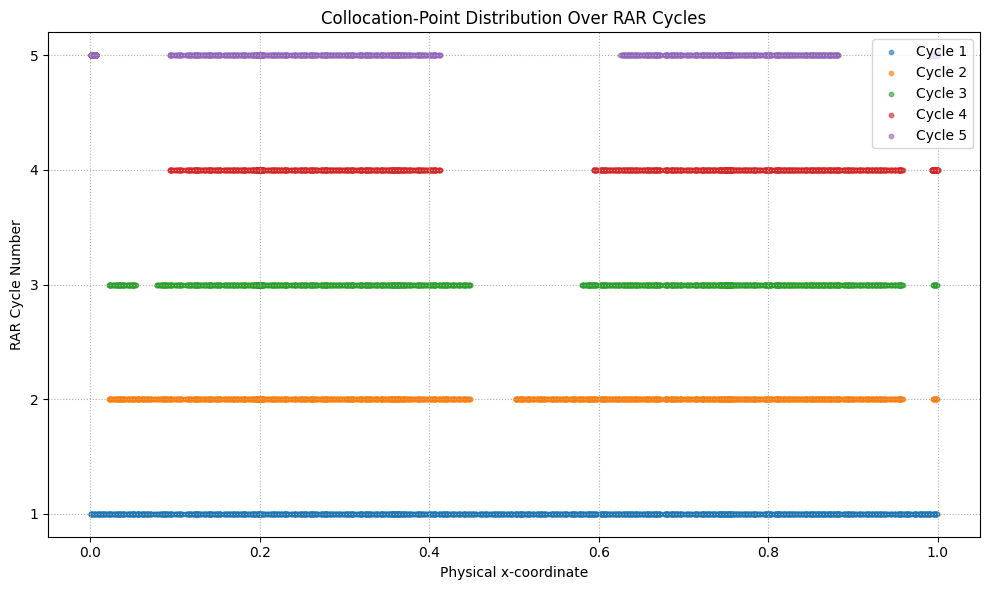

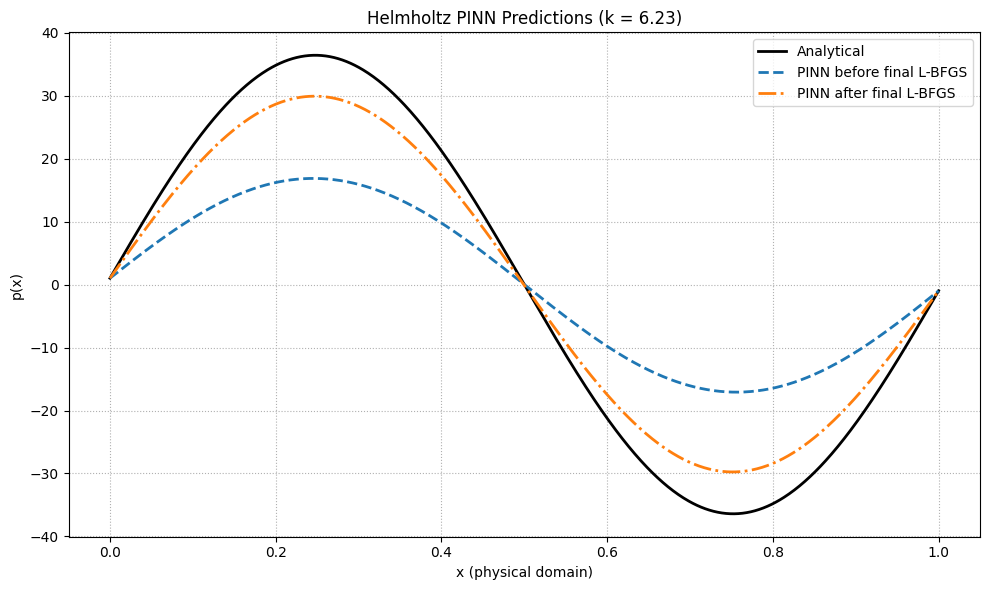

In [14]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_rar_with_preds(
    k,
    A,
    B,
    layers,
    N_colloc=2000,            # you can scale up to 2000 for actual runs
    N_cycles=5,
    iters_per_cycle=100,
    cand_pool=30000,
    refine_frac=0.1,
    c=343.0,
    L=1.0,
    final_lbfgs=True,
    lbfgs_options=None
):
    t0 = time.perf_counter()
    device = torch.device('cpu')

    # --- Define the PINN ---
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.net = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.net:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.net[:-1]:
                y = self.act(lin(y))
            return self.net[-1](y)

    net = PINN(layers).to(device)

    # Trial solution that enforces boundary conditions
    def trial(xh):
        x_phys = (xh + 1) * (L / 2)  # map from [-1,1] → [0,L]
        p_nn = net(xh)
        return (1 - x_phys / L) * A + (x_phys / L) * B + x_phys * (L - x_phys) * p_nn

    # PDE residual: (d²p/dx² + k² p = 0)
    def residual(xh):
        p = trial(xh)
        dp  = torch.autograd.grad(p, xh,
                                  grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]
        d2p = torch.autograd.grad(dp, xh,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return (2.0 / L)**2 * d2p + k**2 * p

    # Initialize collocation points in normalized [-1,1]
    x_colloc = torch.rand(N_colloc, 1, device=device) * 2 - 1
    replace_N = int(refine_frac * N_colloc)

    colloc_history = []  # Will hold physical x-coordinates each cycle

    # --- RAR Cycles (without final global L-BFGS) ---
    for cycle in range(1, N_cycles + 1):
        lbfgs_cycle = torch.optim.LBFGS(
            net.parameters(),
            lr=0.1,
            max_iter=iters_per_cycle,
            tolerance_grad=1e-9,
            tolerance_change=1e-12,
            history_size=50
        )

        def closure_cycle():
            lbfgs_cycle.zero_grad()
            x_req = x_colloc.clone().requires_grad_(True)
            res = residual(x_req)
            loss = torch.mean(res**2)
            loss.backward()
            return loss

        lbfgs_cycle.step(closure_cycle)

        # Record collocation set (in physical domain) after this cycle
        x_phys = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
        colloc_history.append(x_phys)

        # Residual‐based refinement:
        x_cand = (torch.rand(cand_pool, 1, device=device) * 2 - 1).requires_grad_(True)
        r_cand = residual(x_cand).abs().flatten().detach()
        idx_top = torch.topk(r_cand, replace_N).indices
        x_add = x_cand[idx_top].detach()

        x_req2 = x_colloc.clone().detach().requires_grad_(True)
        r_coll = residual(x_req2).abs().flatten().detach()
        idx_keep = torch.topk(r_coll, N_colloc - replace_N).indices
        x_colloc = torch.cat([x_colloc[idx_keep], x_add], dim=0)

        print(f"Cycle {cycle:2d} completed – recorded collocation points.")

    # --- Before final global L-BFGS: record a “pre‐final” prediction ---
    # Build a fine grid in normalized space for plotting
    x_plot = torch.linspace(-1, 1, 800).unsqueeze(-1).to(device)  # 800 points in [-1,1]
    with torch.no_grad():
        p_pre = trial(x_plot).cpu().numpy().flatten()

    # Map x_plot → physical domain for both PINN and analytical
    x_phys_plot = ((x_plot + 1) * (L / 2)).cpu().numpy().flatten()

    # If requested, run a final global L-BFGS pass:
    if final_lbfgs:
        opts = dict(lr=0.1,
                    max_iter=2000,
                    tolerance_grad=1e-9,
                    tolerance_change=1e-12,
                    history_size=50)
        if lbfgs_options:
            opts.update(lbfgs_options)

        lbfgs_final = torch.optim.LBFGS(net.parameters(), **opts)

        def closure_final():
            lbfgs_final.zero_grad()
            x_in = x_colloc.clone().detach().requires_grad_(True)
            res = residual(x_in)
            loss = torch.mean(res**2)
            loss.backward()
            return loss

        lbfgs_final.step(closure_final)
        print("Final global L-BFGS completed.")

    # Record a “post‐final” prediction:
    with torch.no_grad():
        p_post = trial(x_plot).cpu().numpy().flatten()

    elapsed = time.perf_counter() - t0
    print(f"Total time: {elapsed:.1f}s")

    # Analytical (closed‐form) Helmholtz solution on [0,L]:
    x_np   = x_phys_plot
    p_true = (A * np.cos(k * x_np)
              + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_np))

    return {
        "colloc_history": colloc_history,
        "x_phys_plot": x_np,
        "p_pre": p_pre,
        "p_post": p_post,
        "p_true": p_true,
        "k": k
    }


if __name__ == "__main__":
    # Example parameters (you can restore your original sizes once verified)
    freq  = 340
    c_val = 343.0
    k_val = 2 * np.pi * freq / c_val
    A_val = 1.0
    B_val = -1.0

    result = solve_helmholtz_pinn_rar_with_preds(
        k=k_val,
        A=A_val,
        B=B_val,
        layers=[1, 120, 120, 120, 1],  # your original network
        N_colloc=2000,                  # or 2000 for full accuracy
        N_cycles=5,
        iters_per_cycle=100,
        cand_pool=30000,
        refine_frac=0.1,
        L=1.0,
        final_lbfgs=True
    )

    # --- Plot 1: Collocation sets across cycles ---
    plt.figure(figsize=(10, 6))
    for idx, x_vals in enumerate(result["colloc_history"]):
        y_vals = np.full_like(x_vals, idx + 1)
        plt.scatter(x_vals, y_vals, s=10, alpha=0.6, label=f'Cycle {idx + 1}')
    plt.xlabel('Physical x-coordinate')
    plt.ylabel('RAR Cycle Number')
    plt.title('Collocation-Point Distribution Over RAR Cycles')
    plt.yticks(range(1, len(result["colloc_history"]) + 1))
    plt.grid(True, linestyle=':')
    plt.legend(loc='upper right')
    plt.tight_layout()

    # --- Plot 2: Predictions before vs. after final L-BFGS (plus analytical) ---
    plt.figure(figsize=(10, 6))
    x_np   = result["x_phys_plot"]
    p_true = result["p_true"]
    p_pre  = result["p_pre"]
    p_post = result["p_post"]

    plt.plot(x_np, p_true,  label='Analytical', color='black', linewidth=2)
    plt.plot(x_np, p_pre,   '--', label='PINN before final L-BFGS', linewidth=2)
    plt.plot(x_np, p_post,  '-.', label='PINN after final L-BFGS', linewidth=2)
    plt.xlabel('x (physical domain)')
    plt.ylabel('p(x)')
    plt.title(f'Helmholtz PINN Predictions (k = {result["k"]:.2f})')
    plt.legend()
    plt.grid(which='both', linestyle=':')
    plt.tight_layout()
    plt.show()


Recorded initial collocation set (before RAR).
Recorded collocation set after RAR Cycle 1 refinement.
Recorded collocation set after RAR Cycle 2 refinement.
Recorded collocation set after RAR Cycle 3 refinement.
Recorded collocation set after RAR Cycle 4 refinement.
Recorded collocation set after RAR Cycle 5 refinement.
Final global L-BFGS completed.
Total time: 229.4s


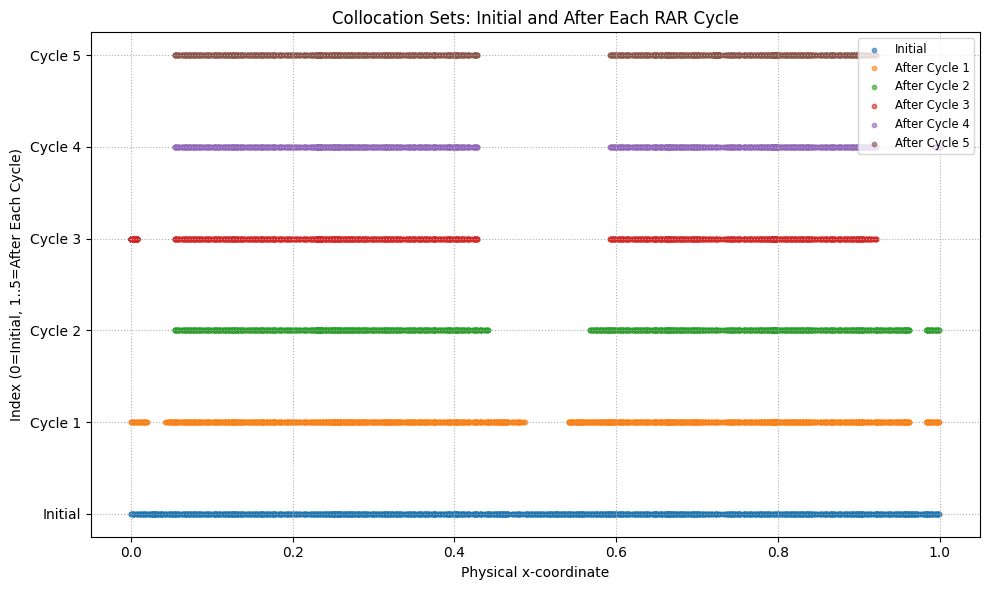

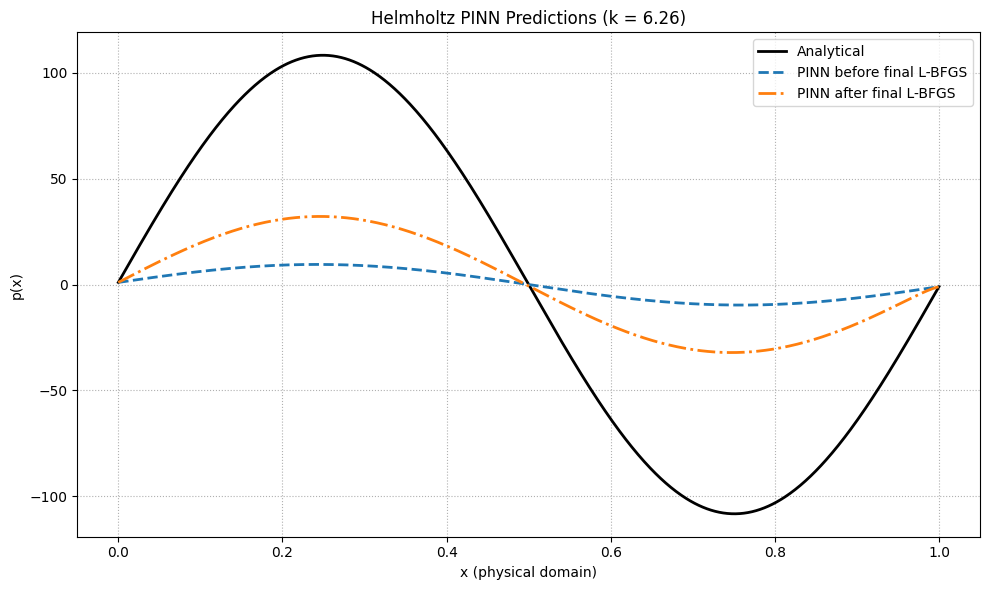

In [ ]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_rar_with_preds(
    k,
    A,
    B,
    layers,
    N_colloc=2000,            # scale up to 2000 for full runs
    N_cycles=5,
    iters_per_cycle=100,
    cand_pool=30000,
    refine_frac=0.1,
    c=343.0,
    L=1.0,
    final_lbfgs=True,
    lbfgs_options=None
):
    t0 = time.perf_counter()
    device = torch.device('cpu')

    # --- Define the PINN network ---
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.net = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.net:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.net[:-1]:
                y = self.act(lin(y))
            return self.net[-1](y)

    net = PINN(layers).to(device)

    # Trial solution that enforces boundary conditions
    def trial(xh):
        x_phys = (xh + 1) * (L / 2)  # map from [-1,1] → [0,L]
        p_nn = net(xh)
        return (1 - x_phys / L) * A + (x_phys / L) * B + x_phys * (L - x_phys) * p_nn

    # PDE residual: (d²p/dx² + k² p = 0)
    def residual(xh):
        p = trial(xh)
        dp  = torch.autograd.grad(p, xh,
                                  grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]
        d2p = torch.autograd.grad(dp, xh,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return (2.0 / L)**2 * d2p + k**2 * p

    # --- Initialize collocation points in normalized space [-1,1] ---
    x_colloc = torch.rand(N_colloc, 1, device=device) * 2 - 1
    replace_N = int(refine_frac * N_colloc)

    colloc_history = []  # Will hold physical x-coordinates for cycles 0,1,...,N_cycles

    # Record the very first (original) collocation set before any RAR:
    x_phys_initial = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
    colloc_history.append(x_phys_initial)
    print("Recorded initial collocation set (before RAR).")

    # --- RAR Cycles (no final L-BFGS yet) ---
    for cycle in range(1, N_cycles + 1):
        lbfgs_cycle = torch.optim.LBFGS(
            net.parameters(),
            lr=0.1,
            max_iter=iters_per_cycle,
            tolerance_grad=1e-9,
            tolerance_change=1e-12,
            history_size=50
        )

        def closure_cycle():
            lbfgs_cycle.zero_grad()
            x_req = x_colloc.clone().requires_grad_(True)
            res = residual(x_req)
            loss = torch.mean(res**2)
            loss.backward()
            return loss

        lbfgs_cycle.step(closure_cycle)

        # --- Residual-based refinement (replace worst with best candidates) ---
        x_cand = (torch.rand(cand_pool, 1, device=device) * 2 - 1).requires_grad_(True)
        r_cand = residual(x_cand).abs().flatten().detach()
        idx_top = torch.topk(r_cand, replace_N).indices
        x_add = x_cand[idx_top].detach()

        x_req2 = x_colloc.clone().detach().requires_grad_(True)
        r_coll = residual(x_req2).abs().flatten().detach()
        idx_keep = torch.topk(r_coll, N_colloc - replace_N).indices
        x_colloc = torch.cat([x_colloc[idx_keep], x_add], dim=0)

        # Record collocation set _after_ refinement this cycle
        x_phys_after = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
        colloc_history.append(x_phys_after)
        print(f"Recorded collocation set after RAR Cycle {cycle} refinement.")

    # --- Record “pre-final” prediction on fine grid (normalized) ---
    x_plot = torch.linspace(-1, 1, 800).unsqueeze(-1).to(device)  
    with torch.no_grad():
        p_pre = trial(x_plot).cpu().numpy().flatten()
    x_phys_plot = ((x_plot + 1) * (L / 2)).cpu().numpy().flatten()

    # --- Final global L-BFGS pass (optional) ---
    if final_lbfgs:
        opts = dict(lr=0.1,
                    max_iter=2000,
                    tolerance_grad=1e-9,
                    tolerance_change=1e-12,
                    history_size=50)
        if lbfgs_options:
            opts.update(lbfgs_options)

        lbfgs_final = torch.optim.LBFGS(net.parameters(), **opts)
        def closure_final():
            lbfgs_final.zero_grad()
            x_in = x_colloc.clone().detach().requires_grad_(True)
            res = residual(x_in)
            loss = torch.mean(res**2)
            loss.backward()
            return loss

        lbfgs_final.step(closure_final)
        print("Final global L-BFGS completed.")

    # --- Record “post-final” prediction on same fine grid ---
    with torch.no_grad():
        p_post = trial(x_plot).cpu().numpy().flatten()

    elapsed = time.perf_counter() - t0
    print(f"Total time: {elapsed:.1f}s")

    # Analytical (closed-form) Helmholtz solution on [0,L]:
    x_np   = x_phys_plot
    p_true = (A * np.cos(k * x_np)
              + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_np))

    return {
        "colloc_history": colloc_history,  # length = N_cycles+1 (index 0 = initial)
        "x_phys_plot": x_np,
        "p_pre": p_pre,
        "p_post": p_post,
        "p_true": p_true,
        "k": k
    }


if __name__ == "__main__":
    # Example parameters (restore to full sizes afterward):
    freq  = 339
    c_val = 340
    k_val = 2 * np.pi * freq / c_val
    A_val = 1.0
    B_val = -1.0

    result = solve_helmholtz_pinn_rar_with_preds(
        k=k_val,
        A=A_val,
        B=B_val,
        layers=[1, 120, 120, 120, 1],  # original network
        N_colloc=5000,                  # set to 2000 for production runs
        N_cycles=5,
        iters_per_cycle=100,
        cand_pool=30000,
        refine_frac=0.1,
        L=1.0,
        final_lbfgs=True
    )

    # --- Plot 1: Collocation sets (including initial) ---
    plt.figure(figsize=(10, 6))
    all_history = result["colloc_history"]
    # all_history[0] = initial; then [1] = after cycle 1, ..., [5] = after cycle 5
    for idx, x_vals in enumerate(all_history):
        y_vals = np.full_like(x_vals, idx)  # use idx=0 for “Initial”, idx=1..5 for cycles
        label = "Initial" if idx == 0 else f'After Cycle {idx}'
        plt.scatter(x_vals, y_vals, s=10, alpha=0.6, label=label)

    plt.xlabel('Physical x-coordinate')
    plt.ylabel('Index (0=Initial, 1..5=After Each Cycle)')
    plt.yticks(range(len(all_history)),
               ["Initial"] + [f'Cycle {i}' for i in range(1, len(all_history))])
    plt.title('Collocation Sets: Initial and After Each RAR Cycle')
    plt.grid(True, linestyle=':')
    plt.legend(loc='upper right', fontsize='small')
    plt.tight_layout()

    # --- Plot 2: Predictions before vs. after final L-BFGS (plus analytical) ---
    plt.figure(figsize=(10, 6))
    x_np   = result["x_phys_plot"]
    p_true = result["p_true"]
    p_pre  = result["p_pre"]
    p_post = result["p_post"]

    plt.plot(x_np, p_true,  label='Analytical', color='black', linewidth=2)
    plt.plot(x_np, p_pre,   '--', label='PINN before final L-BFGS', linewidth=2)
    plt.plot(x_np, p_post,  '-.', label='PINN after final L-BFGS', linewidth=2)
    plt.xlabel('x (physical domain)')
    plt.ylabel('p(x)')
    plt.title(f'Helmholtz PINN Predictions (k = {result["k"]:.2f})')
    plt.legend()
    plt.grid(which='both', linestyle=':')
    plt.tight_layout()

    plt.show()


Printing LBFGS loss

Recorded initial collocation set (before RAR).
Recorded collocation set after RAR Cycle 1 refinement.
Recorded collocation set after RAR Cycle 2 refinement.
Recorded collocation set after RAR Cycle 3 refinement.
Recorded collocation set after RAR Cycle 4 refinement.
Recorded collocation set after RAR Cycle 5 refinement.
Final L-BFGS call 500: loss = 2.448e+02
Final L-BFGS call 1000: loss = 2.860e+00
Final L-BFGS call 1500: loss = 1.172e-01
Final global L-BFGS completed.
Total time: 155.1s


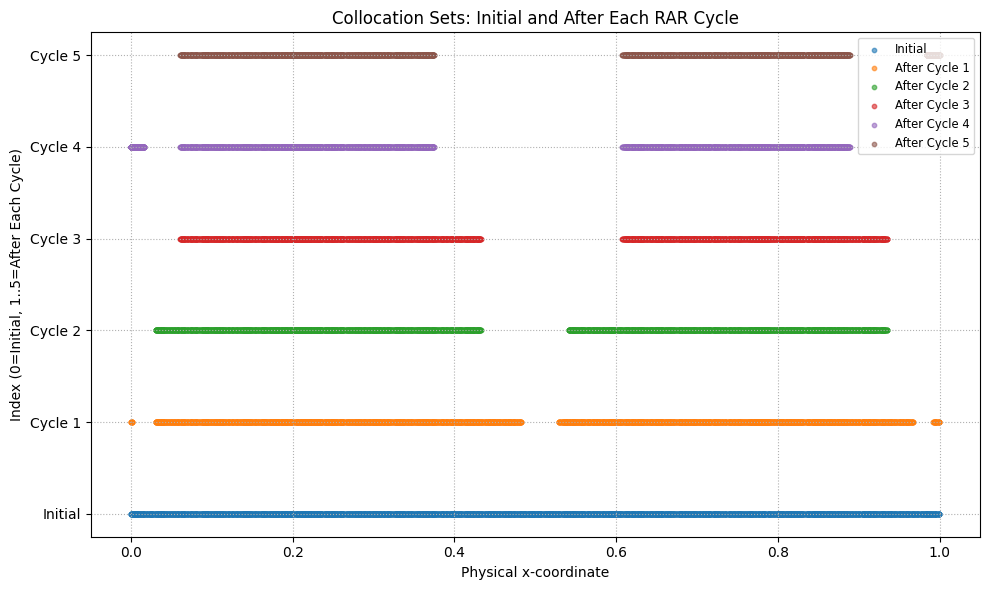

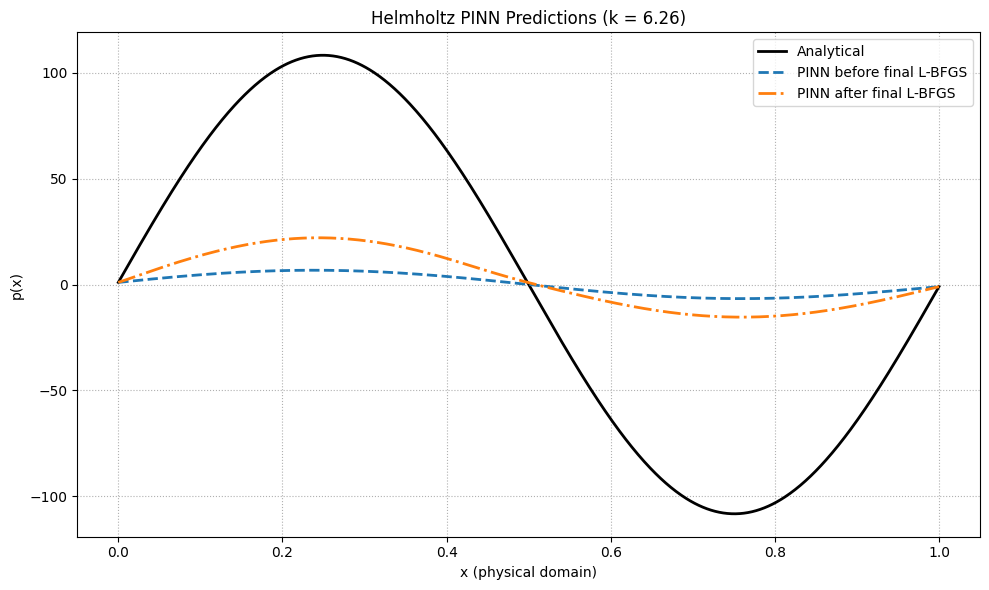

In [25]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_rar_with_preds(
    k,
    A,
    B,
    layers,
    N_colloc=5000,            # scale up to 2000 for full runs
    N_cycles=5,
    iters_per_cycle=100,
    cand_pool=30000,
    refine_frac=0.1,
    c=343.0,
    L=1.0,
    final_lbfgs=True,
    lbfgs_options=None
):
    t0 = time.perf_counter()
    device = torch.device('cpu')

    # --- Define the PINN network ---
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.net = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.net:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.net[:-1]:
                y = self.act(lin(y))
            return self.net[-1](y)

    net = PINN(layers).to(device)

    # Trial solution that enforces boundary conditions
    def trial(xh):
        x_phys = (xh + 1) * (L / 2)  # map from [-1,1] → [0,L]
        p_nn = net(xh)
        return (1 - x_phys / L) * A + (x_phys / L) * B + x_phys * (L - x_phys) * p_nn

    # PDE residual: (d²p/dx² + k² p = 0)
    def residual(xh):
        p = trial(xh)
        dp  = torch.autograd.grad(p, xh,
                                  grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]
        d2p = torch.autograd.grad(dp, xh,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return (2.0 / L)**2 * d2p + k**2 * p

    # --- Initialize collocation points in normalized space [-1,1] ---
    x_colloc = torch.rand(N_colloc, 1, device=device) * 2 - 1
    replace_N = int(refine_frac * N_colloc)

    colloc_history = []  # Will hold physical x-coordinates for cycles 0,1,...,N_cycles

    # Record the very first (original) collocation set before any RAR:
    x_phys_initial = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
    colloc_history.append(x_phys_initial)
    print("Recorded initial collocation set (before RAR).")

    # --- RAR Cycles (no final L-BFGS yet) ---
    for cycle in range(1, N_cycles + 1):
        lbfgs_cycle = torch.optim.LBFGS(
            net.parameters(),
            lr=0.1,
            max_iter=iters_per_cycle,
            tolerance_grad=1e-9,
            tolerance_change=1e-12,
            history_size=50
        )

        def closure_cycle():
            lbfgs_cycle.zero_grad()
            x_req = x_colloc.clone().requires_grad_(True)
            res = residual(x_req)
            loss = torch.mean(res**2)
            loss.backward()
            return loss

        lbfgs_cycle.step(closure_cycle)

        # --- Residual-based refinement (replace worst with best candidates) ---
        x_cand = (torch.rand(cand_pool, 1, device=device) * 2 - 1).requires_grad_(True)
        r_cand = residual(x_cand).abs().flatten().detach()
        idx_top = torch.topk(r_cand, replace_N).indices
        x_add = x_cand[idx_top].detach()

        x_req2 = x_colloc.clone().detach().requires_grad_(True)
        r_coll = residual(x_req2).abs().flatten().detach()
        idx_keep = torch.topk(r_coll, N_colloc - replace_N).indices
        x_colloc = torch.cat([x_colloc[idx_keep], x_add], dim=0)

        # Record collocation set _after_ refinement this cycle
        x_phys_after = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
        colloc_history.append(x_phys_after)
        print(f"Recorded collocation set after RAR Cycle {cycle} refinement.")

    # --- Record “pre-final” prediction on fine grid (normalized) ---
    x_plot = torch.linspace(-1, 1, 800).unsqueeze(-1).to(device)  
    with torch.no_grad():
        p_pre = trial(x_plot).cpu().numpy().flatten()
    x_phys_plot = ((x_plot + 1) * (L / 2)).cpu().numpy().flatten()

    # --- Final global L-BFGS pass (optional) with periodic loss prints ---
    if final_lbfgs:
        opts = dict(lr=0.1,
                    max_iter=2000,
                    tolerance_grad=1e-9,
                    tolerance_change=1e-12,
                    history_size=50)
        if lbfgs_options:
            opts.update(lbfgs_options)

        lbfgs_final = torch.optim.LBFGS(net.parameters(), **opts)

        # counter to track closure calls
        lf_counter = {"count": 0}

        def closure_final():
            lbfgs_final.zero_grad()
            x_in = x_colloc.clone().detach().requires_grad_(True)
            res = residual(x_in)
            loss = torch.mean(res**2)
            loss.backward()

            # increment counter and print every 500 calls
            lf_counter["count"] += 1
            if lf_counter["count"] % 500 == 0:
                print(f"Final L-BFGS call {lf_counter['count']}: loss = {loss.item():.3e}")
            return loss

        lbfgs_final.step(closure_final)
        print("Final global L-BFGS completed.")

    # --- Record “post-final” prediction on same fine grid ---
    with torch.no_grad():
        p_post = trial(x_plot).cpu().numpy().flatten()

    elapsed = time.perf_counter() - t0
    print(f"Total time: {elapsed:.1f}s")

    # Analytical (closed-form) Helmholtz solution on [0,L]:
    x_np   = x_phys_plot
    p_true = (A * np.cos(k * x_np)
              + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_np))

    return {
        "colloc_history": colloc_history,  # length = N_cycles+1 (index 0 = initial)
        "x_phys_plot": x_np,
        "p_pre": p_pre,
        "p_post": p_post,
        "p_true": p_true,
        "k": k
    }


if __name__ == "__main__":
    # Example parameters (restore to full sizes afterward):
    freq  = 339
    c_val = 340
    k_val = 2 * np.pi * freq / c_val
    A_val = 1.0
    B_val = -1.0

    result = solve_helmholtz_pinn_rar_with_preds(
        k=k_val,
        A=A_val,
        B=B_val,
        layers=[1, 120, 120, 120, 120, 1],  # original network
        N_colloc=5000,                  # set to 2000 for production runs
        N_cycles=5,
        iters_per_cycle=100,
        cand_pool=30000,
        refine_frac=0.1,
        L=1.0,
        final_lbfgs=True
    )

    # --- Plot 1: Collocation sets (including initial) ---
    plt.figure(figsize=(10, 6))
    all_history = result["colloc_history"]
    # all_history[0] = initial; then [1] = after cycle 1, ..., [5] = after cycle 5
    for idx, x_vals in enumerate(all_history):
        y_vals = np.full_like(x_vals, idx)  # use idx=0 for “Initial”, idx=1..5 for cycles
        label = "Initial" if idx == 0 else f'After Cycle {idx}'
        plt.scatter(x_vals, y_vals, s=10, alpha=0.6, label=label)

    plt.xlabel('Physical x-coordinate')
    plt.ylabel('Index (0=Initial, 1..5=After Each Cycle)')
    plt.yticks(range(len(all_history)),
               ["Initial"] + [f'Cycle {i}' for i in range(1, len(all_history))])
    plt.title('Collocation Sets: Initial and After Each RAR Cycle')
    plt.grid(True, linestyle=':')
    plt.legend(loc='upper right', fontsize='small')
    plt.tight_layout()

    # --- Plot 2: Predictions before vs. after final L-BFGS (plus analytical) ---
    plt.figure(figsize=(10, 6))
    x_np   = result["x_phys_plot"]
    p_true = result["p_true"]
    p_pre  = result["p_pre"]
    p_post = result["p_post"]

    plt.plot(x_np, p_true,  label='Analytical', color='black', linewidth=2)
    plt.plot(x_np, p_pre,   '--', label='PINN before final L-BFGS', linewidth=2)
    plt.plot(x_np, p_post,  '-.', label='PINN after final L-BFGS', linewidth=2)
    plt.xlabel('x (physical domain)')
    plt.ylabel('p(x)')
    plt.title(f'Helmholtz PINN Predictions (k = {result["k"]:.2f})')
    plt.legend()
    plt.grid(which='both', linestyle=':')
    plt.tight_layout()

    plt.show()


Relative Error Calculation

Recorded initial collocation set (before RAR).
Recorded collocation set after RAR Cycle 1 refinement.
Recorded collocation set after RAR Cycle 2 refinement.
Recorded collocation set after RAR Cycle 3 refinement.
Recorded collocation set after RAR Cycle 4 refinement.
Recorded collocation set after RAR Cycle 5 refinement.
Final L-BFGS call 500: loss = 3.713e+04
Final L-BFGS call 1000: loss = 9.961e+03
Final L-BFGS call 1500: loss = 2.883e+03
Final L-BFGS call 2000: loss = 1.349e+03
Final global L-BFGS completed.
Total time: 54.1s
Final relative error δp (post-final L-BFGS) = 1.020e+00


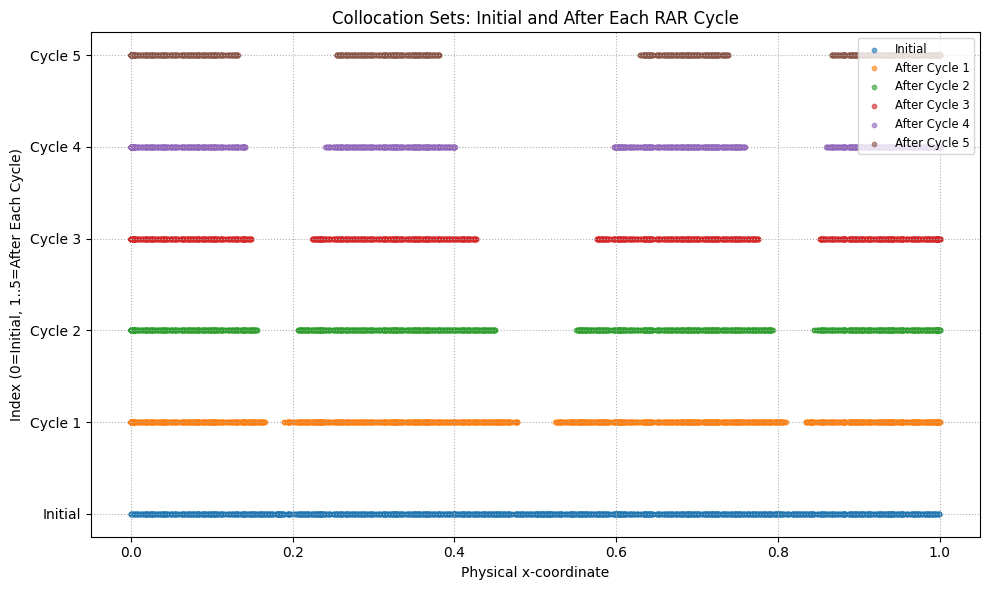

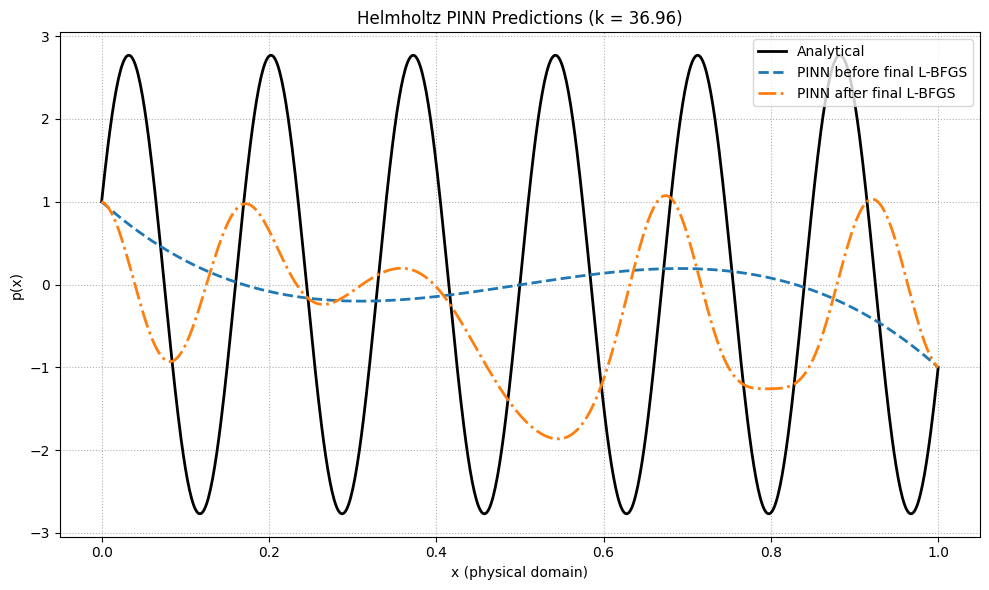

In [24]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_rar_with_preds(
    k,
    A,
    B,
    layers,
    N_colloc=2000,            # scale up to 2000 for full runs
    N_cycles=5,
    iters_per_cycle=100,
    cand_pool=30000,
    refine_frac=0.1,
    c=340.0,
    L=1.0,
    final_lbfgs=True,
    N_test=500                # number of test points for error calculation
):
    t0 = time.perf_counter()
    device = torch.device('cpu')

    # --- Define the PINN network ---
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.net = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.net:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.net[:-1]:
                y = self.act(lin(y))
            return self.net[-1](y)

    net = PINN(layers).to(device)

    # Trial solution that enforces boundary conditions
    def trial(xh):
        x_phys = (xh + 1) * (L / 2)  # map from [-1,1] → [0,L]
        p_nn = net(xh)
        return (1 - x_phys / L) * A + (x_phys / L) * B + x_phys * (L - x_phys) * p_nn

    # PDE residual: (d²p/dx² + k² p = 0)
    def residual(xh):
        p = trial(xh)
        dp  = torch.autograd.grad(p, xh,
                                  grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]
        d2p = torch.autograd.grad(dp, xh,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return (2.0 / L)**2 * d2p + k**2 * p

    # --- Initialize collocation points in normalized space [-1,1] ---
    x_colloc = torch.rand(N_colloc, 1, device=device) * 2 - 1
    replace_N = int(refine_frac * N_colloc)

    colloc_history = []  # Will hold physical x-coordinates for cycles 0,1,...,N_cycles

    # Record the very first (original) collocation set before any RAR:
    x_phys_initial = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
    colloc_history.append(x_phys_initial)
    print("Recorded initial collocation set (before RAR).")

    # --- RAR Cycles (no final L-BFGS yet) ---
    for cycle in range(1, N_cycles + 1):
        lbfgs_cycle = torch.optim.LBFGS(
            net.parameters(),
            lr=0.1,
            max_iter=iters_per_cycle,
            tolerance_grad=1e-12,
            tolerance_change=1e-14,
            history_size=50
        )

        def closure_cycle():
            lbfgs_cycle.zero_grad()
            x_req = x_colloc.clone().requires_grad_(True)
            res = residual(x_req)
            loss = torch.mean(res**2)
            loss.backward()
            return loss

        lbfgs_cycle.step(closure_cycle)

        # --- Residual-based refinement (replace worst with best candidates) ---
        x_cand = (torch.rand(cand_pool, 1, device=device) * 2 - 1).requires_grad_(True)
        r_cand = residual(x_cand).abs().flatten().detach()
        idx_top = torch.topk(r_cand, replace_N).indices
        x_add = x_cand[idx_top].detach()

        x_req2 = x_colloc.clone().detach().requires_grad_(True)
        r_coll = residual(x_req2).abs().flatten().detach()
        idx_keep = torch.topk(r_coll, N_colloc - replace_N).indices
        x_colloc = torch.cat([x_colloc[idx_keep], x_add], dim=0)

        # Record collocation set _after_ refinement this cycle
        x_phys_after = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
        colloc_history.append(x_phys_after)
        print(f"Recorded collocation set after RAR Cycle {cycle} refinement.")

    # --- Record “pre-final” prediction on fine grid (normalized) ---
    x_plot = torch.linspace(-1, 1, 800).unsqueeze(-1).to(device)  
    with torch.no_grad():
        p_pre = trial(x_plot).cpu().numpy().flatten()
    x_phys_plot = ((x_plot + 1) * (L / 2)).cpu().numpy().flatten()

    # --- Final global L-BFGS pass (optional) with periodic loss prints ---
    if final_lbfgs:
        opts = dict(lr=0.1,
                    max_iter=2000,
                    tolerance_grad=1e-12,
                    tolerance_change=1e-14,
                    history_size=50)

        lbfgs_final = torch.optim.LBFGS(net.parameters(), **opts)

        # counter to track closure calls
        lf_counter = {"count": 0}

        def closure_final():
            lbfgs_final.zero_grad()
            x_in = x_colloc.clone().detach().requires_grad_(True)
            res = residual(x_in)
            loss = torch.mean(res**2)
            loss.backward()

            # increment counter and print every 500 calls
            lf_counter["count"] += 1
            if lf_counter["count"] % 500 == 0:
                print(f"Final L-BFGS call {lf_counter['count']}: loss = {loss.item():.3e}")
            return loss

        lbfgs_final.step(closure_final)
        print("Final global L-BFGS completed.")

    # --- Record “post-final” prediction on same fine grid ---
    with torch.no_grad():
        p_post = trial(x_plot).cpu().numpy().flatten()

    elapsed = time.perf_counter() - t0
    print(f"Total time: {elapsed:.1f}s")

    # Analytical (closed-form) Helmholtz solution on [0,L] at the same x_phys_plot:
    x_np   = x_phys_plot
    p_true = (A * np.cos(k * x_np)
              + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_np))

    # --- Compute Relative Error δp using N_test points ---
    # Generate N_test equally spaced points in [0, L]
    x_test = np.linspace(0, L, N_test)
    # Analytical values at x_test:
    p_test_true = (A * np.cos(k * x_test)
                   + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_test))

    # PINN prediction at x_test: we need to map x_test to normalized [-1,1]
    xh_test = 2 * (x_test / L) - 1
    xh_test_tensor = torch.from_numpy(xh_test.reshape(-1, 1).astype(np.float32)).to(device)
    with torch.no_grad():
        p_test_pred = trial(xh_test_tensor).cpu().numpy().flatten()

    # Compute δp:
    numerator   = np.sum((p_test_pred - p_test_true)**2)
    denominator = np.sum((p_test_true)**2)
    delta_p     = np.sqrt(numerator / denominator)

    print(f"Final relative error δp (post-final L-BFGS) = {delta_p:.3e}")

    return {
        "colloc_history": colloc_history,  # length = N_cycles+1 (index 0 = initial)
        "x_phys_plot": x_np,
        "p_pre": p_pre,
        "p_post": p_post,
        "p_true": p_true,
        "delta_p": delta_p,
        "k": k
    }


if __name__ == "__main__":
    # Example parameters (restore to full sizes afterward):
    freq  = 2000
    c_val = 340
    k_val = 2 * np.pi * freq / c_val
    A_val = 1.0
    B_val = -1.0

    result = solve_helmholtz_pinn_rar_with_preds(
        k=k_val,
        A=A_val,
        B=B_val,
        layers=[1, 120, 120, 120, 1],  # original network
        N_colloc=2000,                  # set to 2000 for production runs
        N_cycles=5,
        iters_per_cycle=100,
        cand_pool=30000,
        refine_frac=0.1,
        L=1.0,
        final_lbfgs=True,
        N_test=500                      # number of points for relative error
    )

    # --- Plot 1: Collocation sets (including initial) ---
    plt.figure(figsize=(10, 6))
    all_history = result["colloc_history"]
    # all_history[0] = initial; then [1] = after cycle 1, ..., [5] = after cycle 5
    for idx, x_vals in enumerate(all_history):
        y_vals = np.full_like(x_vals, idx)  # use idx=0 for “Initial”, idx=1..5 for cycles
        label = "Initial" if idx == 0 else f'After Cycle {idx}'
        plt.scatter(x_vals, y_vals, s=10, alpha=0.6, label=label)

    plt.xlabel('Physical x-coordinate')
    plt.ylabel('Index (0=Initial, 1..5=After Each Cycle)')
    plt.yticks(range(len(all_history)),
               ["Initial"] + [f'Cycle {i}' for i in range(1, len(all_history))])
    plt.title('Collocation Sets: Initial and After Each RAR Cycle')
    plt.grid(True, linestyle=':')
    plt.legend(loc='upper right', fontsize='small')
    plt.tight_layout()

    # --- Plot 2: Predictions before vs. after final L-BFGS (plus analytical) ---
    plt.figure(figsize=(10, 6))
    x_np   = result["x_phys_plot"]
    p_true = result["p_true"]
    p_pre  = result["p_pre"]
    p_post = result["p_post"]

    plt.plot(x_np, p_true,  label='Analytical', color='black', linewidth=2)
    plt.plot(x_np, p_pre,   '--', label='PINN before final L-BFGS', linewidth=2)
    plt.plot(x_np, p_post,  '-.', label='PINN after final L-BFGS', linewidth=2)
    plt.xlabel('x (physical domain)')
    plt.ylabel('p(x)')
    plt.title(f'Helmholtz PINN Predictions (k = {result["k"]:.2f})')
    plt.legend()
    plt.grid(which='both', linestyle=':')
    plt.tight_layout()

    plt.show()

    # Optionally, you can also read the returned delta_p:
    # print("Returned δp =", result["delta_p"])


Modified version with NaN error fixed (reduced Lr and tolerance values)

Recorded initial collocation set (before RAR).
Recorded collocation set after RAR Cycle 1 refinement.
Recorded collocation set after RAR Cycle 2 refinement.
Recorded collocation set after RAR Cycle 3 refinement.
Recorded collocation set after RAR Cycle 4 refinement.
Recorded collocation set after RAR Cycle 5 refinement.
Final L-BFGS call 500: loss = 2.537e+02
Final L-BFGS call 1000: loss = 1.347e+02
Final L-BFGS call 1500: loss = 5.703e+00
Final L-BFGS call 2000: loss = 1.480e+00
Final global L-BFGS completed.
Total time: 128.9s
Final relative error δp (post-final L-BFGS) = 9.373e-01


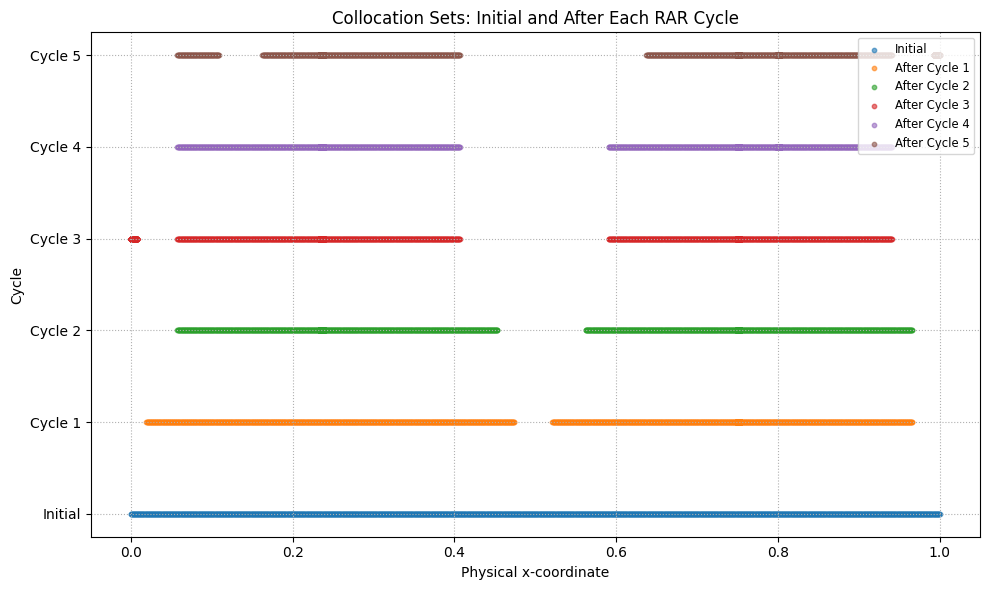

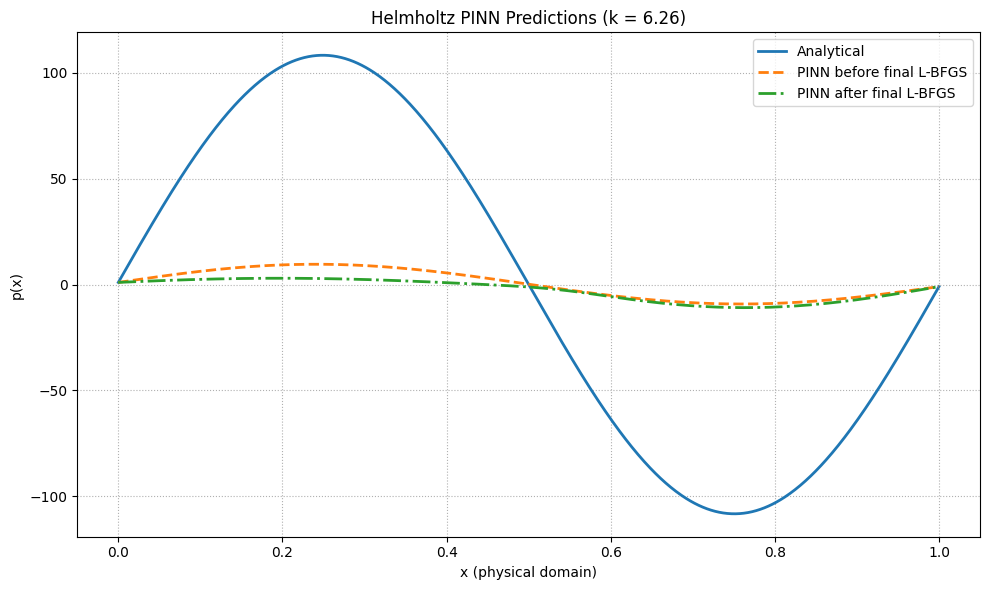

In [5]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_rar_with_preds(
    k,
    A,
    B,
    layers,
    N_colloc=2000,            # scale up to 2000 for full runs
    N_cycles=5,
    iters_per_cycle=100,
    cand_pool=30000,
    refine_frac=0.1,
    c=340.0,
    L=1.0,
    final_lbfgs=True,
    N_test=500                # number of test points for error calculation
):
    t0 = time.perf_counter()
    device = torch.device('cpu')

    # --- Define the PINN network ---
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.net = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.net:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.net[:-1]:
                y = self.act(lin(y))
            return self.net[-1](y)

    net = PINN(layers).to(device)

    # Trial solution that enforces boundary conditions
    def trial(xh):
        x_phys = (xh + 1) * (L / 2)  # map from [-1,1] → [0,L]
        p_nn = net(xh)
        return (1 - x_phys / L) * A + (x_phys / L) * B + x_phys * (L - x_phys) * p_nn

    # PDE residual: (d²p/dx² + k² p = 0)
    def residual(xh):
        p = trial(xh)
        dp  = torch.autograd.grad(p, xh,
                                  grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]
        d2p = torch.autograd.grad(dp, xh,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return (2.0 / L)**2 * d2p + k**2 * p

    # --- Initialize collocation points in normalized space [-1,1] ---
    # Start with a uniform grid, then refine adaptively
    x_colloc = torch.linspace(-1, 1, N_colloc, device=device).unsqueeze(-1)
    replace_N = int(refine_frac * N_colloc)

    colloc_history = []
    x_phys_initial = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
    colloc_history.append(x_phys_initial)
    print("Recorded initial collocation set (before RAR).")

    # --- RAR Cycles ---
    for cycle in range(1, N_cycles + 1):
        lbfgs_cycle = torch.optim.LBFGS(
            net.parameters(),
            lr=0.1,
            max_iter=iters_per_cycle,
            tolerance_grad=1e-12,
            tolerance_change=1e-14,
            history_size=50
        )

        def closure_cycle():
            lbfgs_cycle.zero_grad()
            x_req = x_colloc.clone().requires_grad_(True)
            res = residual(x_req)
            loss = torch.mean(res**2)
            loss.backward()
            return loss

        lbfgs_cycle.step(closure_cycle)

        x_cand = (torch.rand(cand_pool, 1, device=device) * 2 - 1).requires_grad_(True)
        r_cand = residual(x_cand).abs().flatten().detach()
        idx_top = torch.topk(r_cand, replace_N).indices
        x_add = x_cand[idx_top].detach()

        x_req2 = x_colloc.clone().detach().requires_grad_(True)
        r_coll = residual(x_req2).abs().flatten().detach()
        idx_keep = torch.topk(r_coll, N_colloc - replace_N).indices
        x_colloc = torch.cat([x_colloc[idx_keep], x_add], dim=0)

        x_phys_after = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
        colloc_history.append(x_phys_after)
        print(f"Recorded collocation set after RAR Cycle {cycle} refinement.")

    # --- Pre-final prediction on fine grid ---
    x_plot = torch.linspace(-1, 1, 800).unsqueeze(-1).to(device)
    with torch.no_grad():
        p_pre = trial(x_plot).cpu().numpy().flatten()
    x_phys_plot = ((x_plot + 1) * (L / 2)).cpu().numpy().flatten()

    # --- Final global L-BFGS pass (optional) ---
    if final_lbfgs:
        opts = dict(
            lr=0.01,
            max_iter=2000,
            tolerance_grad=1e-9,
            tolerance_change=1e-12,
            history_size=50
        )
        lbfgs_final = torch.optim.LBFGS(net.parameters(), **opts)

        last_finite = None
        def closure_final():
            nonlocal last_finite
            lbfgs_final.zero_grad()
            x_in = x_colloc.clone().detach().requires_grad_(True)
            res = residual(x_in)
            loss = torch.mean(res**2)
            if not torch.isfinite(loss):
                return last_finite if last_finite is not None else loss
            loss.backward()
            last_finite = loss
            closure_final.counter += 1
            if closure_final.counter % 500 == 0:
                print(f"Final L-BFGS call {closure_final.counter}: loss = {loss.item():.3e}")
            return loss
        closure_final.counter = 0

        lbfgs_final.step(closure_final)
        print("Final global L-BFGS completed.")

    with torch.no_grad():
        p_post = trial(x_plot).cpu().numpy().flatten()

    elapsed = time.perf_counter() - t0
    print(f"Total time: {elapsed:.1f}s")

    x_np   = x_phys_plot
    p_true = (A * np.cos(k * x_np)
              + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_np))

    # --- Compute Relative Error δp ---
    x_test = np.linspace(0, L, N_test)
    p_test_true = (A * np.cos(k * x_test)
                   + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_test))
    xh_test = 2 * (x_test / L) - 1
    xh_test_tensor = torch.from_numpy(xh_test.reshape(-1, 1).astype(np.float32)).to(device)
    with torch.no_grad():
        p_test_pred = trial(xh_test_tensor).cpu().numpy().flatten()
    numerator   = np.sum((p_test_pred - p_test_true)**2)
    denominator = np.sum(p_test_true**2)
    delta_p     = np.sqrt(numerator / denominator)
    print(f"Final relative error δp (post-final L-BFGS) = {delta_p:.3e}")

    return {
        "colloc_history": colloc_history,
        "x_phys_plot": x_np,
        "p_pre": p_pre,
        "p_post": p_post,
        "p_true": p_true,
        "delta_p": delta_p,
        "k": k
    }


if __name__ == "__main__":
    freq  = 339
    c_val = 340
    k_val = 2 * np.pi * freq / c_val
    A_val = 1.0
    B_val = -1.0

    result = solve_helmholtz_pinn_rar_with_preds(
        k=k_val,
        A=A_val,
        B=B_val,
        layers=[1, 120, 120, 120, 1],
        N_colloc=2000,
        N_cycles=5,
        iters_per_cycle=100,
        cand_pool=30000,
        refine_frac=0.1,
        L=1.0,
        final_lbfgs=True,
        N_test=500
    )

    # Plot collocation history
    plt.figure(figsize=(10, 6))
    for idx, x_vals in enumerate(result["colloc_history"]):
        y_vals = np.full_like(x_vals, idx)
        label = "Initial" if idx == 0 else f'After Cycle {idx}'
        plt.scatter(x_vals, y_vals, s=10, alpha=0.6, label=label)
    plt.xlabel('Physical x-coordinate')
    plt.ylabel('Cycle')
    plt.yticks(range(len(result["colloc_history"])),
               ["Initial"] + [f'Cycle {i}' for i in range(1, len(result["colloc_history"]))])
    plt.title('Collocation Sets: Initial and After Each RAR Cycle')
    plt.grid(True, linestyle=':')
    plt.legend(loc='upper right', fontsize='small')
    plt.tight_layout()

    # Plot predictions
    plt.figure(figsize=(10, 6))
    x_np   = result["x_phys_plot"]
    p_true = result["p_true"]
    p_pre  = result["p_pre"]
    p_post = result["p_post"]
    plt.plot(x_np, p_true,  label='Analytical', linewidth=2)
    plt.plot(x_np, p_pre,   '--', label='PINN before final L-BFGS', linewidth=2)
    plt.plot(x_np, p_post,  '-.', label='PINN after final L-BFGS', linewidth=2)
    plt.xlabel('x (physical domain)')
    plt.ylabel('p(x)')
    plt.title(f'Helmholtz PINN Predictions (k = {result["k"]:.2f})')
    plt.legend()
    plt.grid(which='both', linestyle=':')
    plt.tight_layout()
    plt.show()


Optimized hyperparameters

Recorded initial collocation set (before RAR).
Recorded collocation set after RAR Cycle 1 refinement.
Recorded collocation set after RAR Cycle 2 refinement.
Recorded collocation set after RAR Cycle 3 refinement.
Recorded collocation set after RAR Cycle 4 refinement.
Recorded collocation set after RAR Cycle 5 refinement.
Recorded collocation set after RAR Cycle 6 refinement.
Final L-BFGS call 500: loss = 1.840e+02
Final L-BFGS call 1000: loss = 1.311e+02
Final L-BFGS call 1500: loss = 6.634e+01
Final L-BFGS call 2000: loss = 2.465e+01
Final global L-BFGS completed.
Total time: 260.8s
Final relative error δp (post-final L-BFGS) = 2.553e-01


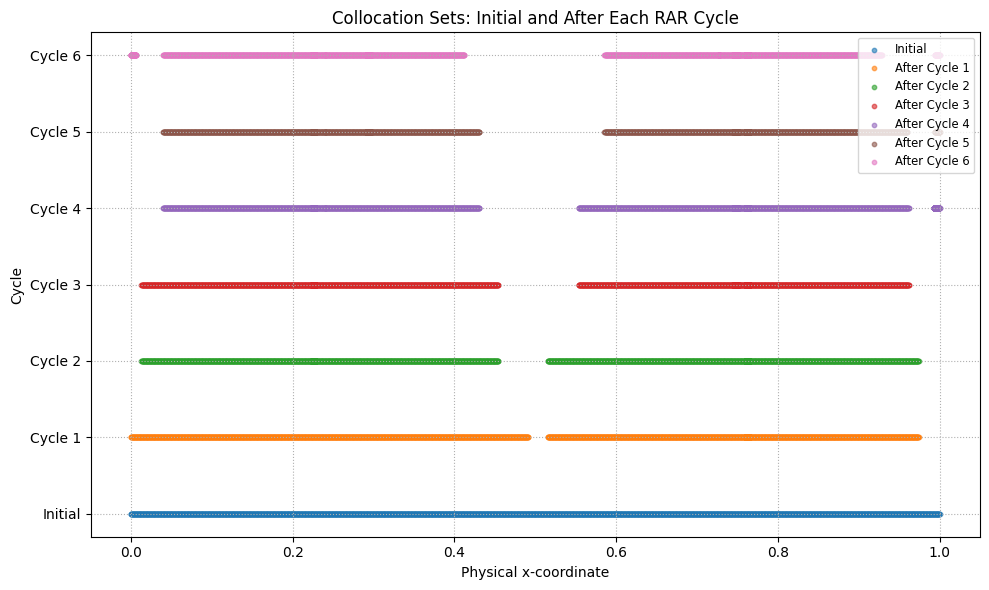

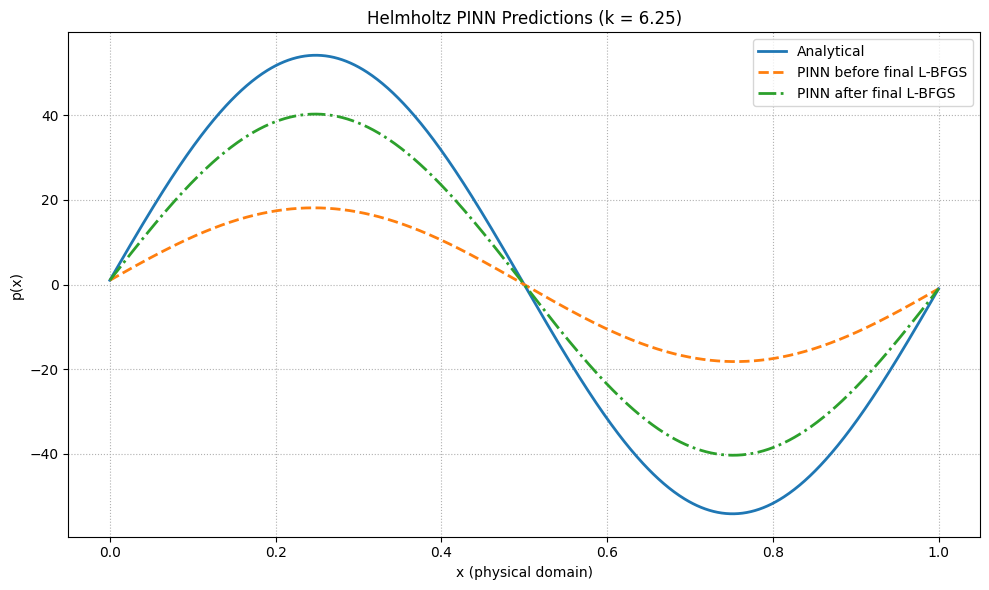

In [15]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_rar_with_preds(
    k,
    A,
    B,
    layers=[1, 150, 150, 150, 1],  # wider network
    N_colloc=3000,                 # up from 2000
    N_cycles=6,                    # up from 5
    iters_per_cycle=200,           # up from 100
    cand_pool=20000,               # down from 30000
    refine_frac=0.05,              # down from 0.1
    c=340.0,
    L=1.0,
    final_lbfgs=True,
    N_test=500
):
    t0 = time.perf_counter()
    device = torch.device('cpu')

    # --- Define the PINN network ---
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.net = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.net:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.net[:-1]:
                y = self.act(lin(y))
            return self.net[-1](y)

    net = PINN(layers).to(device)

    # Trial solution that enforces boundary conditions
    def trial(xh):
        x_phys = (xh + 1) * (L / 2)
        p_nn = net(xh)
        return (1 - x_phys / L) * A + (x_phys / L) * B + x_phys * (L - x_phys) * p_nn

    # PDE residual: (d²p/dx² + k² p = 0)
    def residual(xh):
        p = trial(xh)
        dp  = torch.autograd.grad(p, xh,
                                  grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]
        d2p = torch.autograd.grad(dp, xh,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return (2.0 / L)**2 * d2p + k**2 * p

    # --- Initialize collocation points in normalized space [-1,1] ---
    x_colloc = torch.linspace(-1, 1, N_colloc, device=device).unsqueeze(-1)
    replace_N = int(refine_frac * N_colloc)

    colloc_history = []
    x_phys_initial = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
    colloc_history.append(x_phys_initial)
    print("Recorded initial collocation set (before RAR).")

    # --- RAR Cycles ---
    for cycle in range(1, N_cycles + 1):
        lbfgs_cycle = torch.optim.LBFGS(
            net.parameters(),
            lr=0.05,                   # reduced from 0.1
            max_iter=iters_per_cycle,
            tolerance_grad=1e-12,
            tolerance_change=1e-14,
            history_size=50,
        )

        def closure_cycle():
            lbfgs_cycle.zero_grad()
            x_req = x_colloc.clone().requires_grad_(True)
            res = residual(x_req)
            loss = torch.mean(res**2)
            loss.backward()
            return loss

        lbfgs_cycle.step(closure_cycle)

        x_cand = (torch.rand(cand_pool, 1, device=device) * 2 - 1).requires_grad_(True)
        r_cand = residual(x_cand).abs().flatten().detach()
        idx_top = torch.topk(r_cand, replace_N).indices
        x_add = x_cand[idx_top].detach()

        x_req2 = x_colloc.clone().detach().requires_grad_(True)
        r_coll = residual(x_req2).abs().flatten().detach()
        idx_keep = torch.topk(r_coll, N_colloc - replace_N).indices
        x_colloc = torch.cat([x_colloc[idx_keep], x_add], dim=0)

        x_phys_after = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
        colloc_history.append(x_phys_after)
        print(f"Recorded collocation set after RAR Cycle {cycle} refinement.")

    # --- Pre-final prediction on fine grid ---
    x_plot = torch.linspace(-1, 1, 800).unsqueeze(-1).to(device)
    with torch.no_grad():
        p_pre = trial(x_plot).cpu().numpy().flatten()
    x_phys_plot = ((x_plot + 1) * (L / 2)).cpu().numpy().flatten()

    # --- Final global L-BFGS pass (optional) ---
    if final_lbfgs:
        opts = dict(
            lr=0.005,                  # reduced from 0.01
            max_iter=2000,
            tolerance_grad=1e-9,
            tolerance_change=1e-12,
            history_size=50
        )
        lbfgs_final = torch.optim.LBFGS(net.parameters(), **opts)

        last_finite = None
        def closure_final():
            nonlocal last_finite
            lbfgs_final.zero_grad()
            x_in = x_colloc.clone().detach().requires_grad_(True)
            res = residual(x_in)
            loss = torch.mean(res**2)
            if not torch.isfinite(loss):
                return last_finite if last_finite is not None else loss
            loss.backward()
            last_finite = loss
            closure_final.counter += 1
            if closure_final.counter % 500 == 0:
                print(f"Final L-BFGS call {closure_final.counter}: loss = {loss.item():.3e}")
            return loss
        closure_final.counter = 0

        lbfgs_final.step(closure_final)
        print("Final global L-BFGS completed.")

    with torch.no_grad():
        p_post = trial(x_plot).cpu().numpy().flatten()

    elapsed = time.perf_counter() - t0
    print(f"Total time: {elapsed:.1f}s")

    x_np   = x_phys_plot
    p_true = (A * np.cos(k * x_np)
              + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_np))

    # --- Compute Relative Error δp ---
    x_test = np.linspace(0, L, N_test)
    p_test_true = (A * np.cos(k * x_test)
                   + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_test))
    xh_test = 2 * (x_test / L) - 1
    xh_test_tensor = torch.from_numpy(xh_test.reshape(-1, 1).astype(np.float32)).to(device)
    with torch.no_grad():
        p_test_pred = trial(xh_test_tensor).cpu().numpy().flatten()
    numerator   = np.sum((p_test_pred - p_test_true)**2)
    denominator = np.sum(p_test_true**2)
    delta_p     = np.sqrt(numerator / denominator)
    print(f"Final relative error δp (post-final L-BFGS) = {delta_p:.3e}")

    return {
        "colloc_history": colloc_history,
        "x_phys_plot": x_np,
        "p_pre": p_pre,
        "p_post": p_post,
        "p_true": p_true,
        "delta_p": delta_p,
        "k": k
    }


if __name__ == "__main__":
    freq  = 338
    c_val = 340
    k_val = 2 * np.pi * freq / c_val
    A_val = 1.0
    B_val = -1.0

    result = solve_helmholtz_pinn_rar_with_preds(
        k=k_val,
        A=A_val,
        B=B_val,
        layers=[1, 150, 150, 150, 1],
        N_colloc=3000,
        N_cycles=6,
        iters_per_cycle=200,
        cand_pool=20000,
        refine_frac=0.05,
        L=1.0,
        final_lbfgs=True,
        N_test=500
    )

    # Plot collocation history
    plt.figure(figsize=(10, 6))
    for idx, x_vals in enumerate(result["colloc_history"]):
        y_vals = np.full_like(x_vals, idx)
        label = "Initial" if idx == 0 else f'After Cycle {idx}'
        plt.scatter(x_vals, y_vals, s=10, alpha=0.6, label=label)
    plt.xlabel('Physical x-coordinate')
    plt.ylabel('Cycle')
    plt.yticks(range(len(result["colloc_history"])),
               ["Initial"] + [f'Cycle {i}' for i in range(1, len(result["colloc_history"]))])
    plt.title('Collocation Sets: Initial and After Each RAR Cycle')
    plt.grid(True, linestyle=':')
    plt.legend(loc='upper right', fontsize='small')
    plt.tight_layout()

    # Plot predictions
    plt.figure(figsize=(10, 6))
    x_np   = result["x_phys_plot"]
    p_true = result["p_true"]
    p_pre  = result["p_pre"]
    p_post = result["p_post"]
    plt.plot(x_np, p_true,  label='Analytical', linewidth=2)
    plt.plot(x_np, p_pre,   '--', label='PINN before final L-BFGS', linewidth=2)
    plt.plot(x_np, p_post,  '-.', label='PINN after final L-BFGS', linewidth=2)
    plt.xlabel('x (physical domain)')
    plt.ylabel('p(x)')
    plt.title(f'Helmholtz PINN Predictions (k = {result["k"]:.2f})')
    plt.legend()
    plt.grid(which='both', linestyle=':')
    plt.tight_layout()
    plt.show()


Modified RAR(no removal of points) and GPU code

In [6]:
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def solve_helmholtz_pinn_rar_with_preds(
    k,
    A,
    B,
    layers,
    N_colloc=2000,            # initial collocation points; will only grow
    N_cycles=5,
    iters_per_cycle=100,
    cand_pool=30000,
    refine_frac=0.1,
    c=340.0,
    L=1.0,
    final_lbfgs=True,
    N_test=500                # number of test points for error calculation
):
    t0 = time.perf_counter()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # --- Define the PINN network ---
    class PINN(nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.act = torch.sin
            self.net = nn.ModuleList(
                nn.Linear(layers[i], layers[i+1])
                for i in range(len(layers)-1)
            )
            for lin in self.net:
                nn.init.xavier_normal_(lin.weight)
                nn.init.zeros_(lin.bias)

        def forward(self, x):
            y = x
            for lin in self.net[:-1]:
                y = self.act(lin(y))
            return self.net[-1](y)

    net = PINN(layers).to(device)

    # Trial solution that enforces boundary conditions
    def trial(xh):
        x_phys = (xh + 1) * (L / 2)  # map from [-1,1] → [0,L]
        p_nn = net(xh)
        return (1 - x_phys / L) * A + (x_phys / L) * B + x_phys * (L - x_phys) * p_nn

    # PDE residual: (d²p/dx² + k² p = 0)
    def residual(xh):
        p = trial(xh)
        dp  = torch.autograd.grad(p, xh,
                                  grad_outputs=torch.ones_like(p),
                                  create_graph=True)[0]
        d2p = torch.autograd.grad(dp, xh,
                                  grad_outputs=torch.ones_like(dp),
                                  create_graph=True)[0]
        return (2.0 / L)**2 * d2p + k**2 * p

    # --- Initialize collocation points in normalized space [-1,1] ---
    x_colloc = torch.linspace(-1, 1, N_colloc, device=device).unsqueeze(-1)
    add_N = int(refine_frac * N_colloc)

    colloc_history = []
    x_phys_initial = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
    colloc_history.append(x_phys_initial)
    print(f"Recorded initial collocation set with {x_colloc.shape[0]} points (before RAR).")

    # --- RAR Cycles (additive only, no removals) ---
    for cycle in range(1, N_cycles + 1):
        # L-BFGS training on current set
        lbfgs_cycle = torch.optim.LBFGS(
            net.parameters(),
            lr=0.1,
            max_iter=iters_per_cycle,
            tolerance_grad=1e-12,
            tolerance_change=1e-14,
            history_size=50
        )

        def closure_cycle():
            lbfgs_cycle.zero_grad()
            x_req = x_colloc.clone().requires_grad_(True)
            res = residual(x_req)
            loss = torch.mean(res**2)
            loss.backward()
            return loss

        lbfgs_cycle.step(closure_cycle)

        # Generate candidate points and select top error points
        x_cand = (torch.rand(cand_pool, 1, device=device) * 2 - 1).requires_grad_(True)
        r_cand = residual(x_cand).abs().flatten().detach()
        idx_top = torch.topk(r_cand, add_N).indices
        x_add = x_cand[idx_top].detach()

        # Add new points to collocation set
        x_colloc = torch.cat([x_colloc, x_add], dim=0)
        print(f"Cycle {cycle}: added {add_N} points, total collocation points = {x_colloc.shape[0]}")

        x_phys_after = ((x_colloc + 1) * (L / 2)).detach().cpu().numpy().flatten()
        colloc_history.append(x_phys_after)
        print(f"Recorded collocation set after RAR Cycle {cycle} refinement (added points).")

    # Print final total
    print(f"Total collocation points used after all cycles: {x_colloc.shape[0]}")

    # --- Pre-final prediction on fine grid ---
    x_plot = torch.linspace(-1, 1, 800).unsqueeze(-1).to(device)
    with torch.no_grad():
        p_pre = trial(x_plot).cpu().numpy().flatten()
    x_phys_plot = ((x_plot + 1) * (L / 2)).cpu().numpy().flatten()

    # --- Final global L-BFGS pass (optional) ---
    if final_lbfgs:
        opts = dict(
            lr=0.01,
            max_iter=2000,
            tolerance_grad=1e-9,
            tolerance_change=1e-12,
            history_size=50
        )
        lbfgs_final = torch.optim.LBFGS(net.parameters(), **opts)

        last_finite = None
        def closure_final():
            nonlocal last_finite
            lbfgs_final.zero_grad()
            x_in = x_colloc.clone().detach().requires_grad_(True)
            res = residual(x_in)
            loss = torch.mean(res**2)
            if not torch.isfinite(loss):
                return last_finite if last_finite is not None else loss
            loss.backward()
            last_finite = loss
            closure_final.counter += 1
            if closure_final.counter % 500 == 0:
                print(f"Final L-BFGS call {closure_final.counter}: loss = {loss.item():.3e}")
            return loss
        closure_final.counter = 0

        lbfgs_final.step(closure_final)
        print("Final global L-BFGS completed.")

    with torch.no_grad():
        p_post = trial(x_plot).cpu().numpy().flatten()

    elapsed = time.perf_counter() - t0
    print(f"Total time: {elapsed:.1f}s")

    x_np   = x_phys_plot
    p_true = (A * np.cos(k * x_np)
              + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_np))

    # --- Compute Relative Error δp ---
    x_test = np.linspace(0, L, N_test)
    p_test_true = (A * np.cos(k * x_test)
                   + ((B - A * np.cos(k * L)) / np.sin(k * L)) * np.sin(k * x_test))
    xh_test = 2 * (x_test / L) - 1
    xh_test_tensor = torch.from_numpy(xh_test.reshape(-1, 1).astype(np.float32)).to(device)
    with torch.no_grad():
        p_test_pred = trial(xh_test_tensor).cpu().numpy().flatten()
    numerator   = np.sum((p_test_pred - p_test_true)**2)
    denominator = np.sum(p_test_true**2)
    delta_p     = np.sqrt(numerator / denominator)
    print(f"Final relative error δp (post-final L-BFGS) = {delta_p:.3e}")

    return {
        "colloc_history": colloc_history,
        "x_phys_plot": x_np,
        "p_pre": p_pre,
        "p_post": p_post,
        "p_true": p_true,
        "delta_p": delta_p,
        "k": k
    }

if __name__ == "__main__":
    freq  = 339
    c_val = 340
    k_val = 2 * np.pi * freq / c_val
    A_val = 1.0
    B_val = -1.0

    result = solve_helmholtz_pinn_rar_with_preds(
        k=k_val,
        A=A_val,
        B=B_val,
        layers=[1, 120, 120, 120, 1],
        N_colloc=2000,
        N_cycles=5,
        iters_per_cycle=100,
        cand_pool=30000,
        refine_frac=0.1,
        L=1.0,
        final_lbfgs=True,
        N_test=500
    )

    # Plot collocation history
    plt.figure(figsize=(10, 6))
    for idx, x_vals in enumerate(result["colloc_history"]):
        y_vals = np.full_like(x_vals, idx)
        label = "Initial" if idx == 0 else f'After Cycle {idx}'
        plt.scatter(x_vals, y_vals, s=10, alpha=0.6, label=label)
    plt.xlabel('Physical x-coordinate')
    plt.ylabel('Cycle')
    plt.yticks(range(len(result["colloc_history"])),
               ["Initial"] + [f'Cycle {i}' for i in range(1, len(result["colloc_history"]))])
    plt.title('Collocation Sets: Initial and After Each RAR Cycle')
    plt.grid(True, linestyle=':')
    plt.legend(loc='upper right', fontsize='small')
    plt.tight_layout()

    # Plot predictions
    plt.figure(figsize=(10, 6))
    x_np   = result["x_phys_plot"]
    p_true = result["p_true"]
    p_pre  = result["p_pre"]
    p_post = result["p_post"]
    plt.plot(x_np, p_true,  label='Analytical', linewidth=2)
    plt.plot(x_np, p_pre,   '--', label='PINN before final L-BFGS', linewidth=2)
    plt.plot(x_np, p_post,  '-.', label='PINN after final L-BFGS', linewidth=2)
    plt.xlabel('x (physical domain)')
    plt.ylabel('p(x)')
    plt.title(f'Helmholtz PINN Predictions (k = {result["k"]:.2f})')
    plt.legend()
    plt.grid(which='both', linestyle=':')
    plt.tight_layout()
    plt.show()


Using device: cpu
Recorded initial collocation set with 2000 points (before RAR).


KeyboardInterrupt: 

In [10]:
import torch

if torch.cuda.is_available():
    # Only now is it safe to query device properties
    print("CUDA is available on:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available (torch.cuda.is_available() is False).")


CUDA is not available (torch.cuda.is_available() is False).
